In [27]:
#unzipping the data
! unzip Nrms1p0.zip -d full_noise
# trainImages.zip

Archive:  Nrms1p0.zip
replace full_noise/Nrms1p0/V0F0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [28]:
#pip install --upgrade pip

In [29]:
#!pip3 install xgboost

In [30]:
## Importing relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

In [31]:
#imports
import glob
import os
import cv2
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v,sobel_h,sobel_v
import matplotlib.pyplot as plt
%matplotlib inline
#from tensorflow import keras
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import xgboost as xgb

In [46]:
#separates images according to volume and frame
#img_path: image path (including VXFY)
#ew: boolean that defines whether we are looking at the north/south separation (F) or east/west separation (V)
#returns an integer of either V or F
def separation(img_path, ew):
    substr = img_path[-10:]
    if ew == True:
        ew_str = ""
        for letter in substr[-6:]:
            if letter.isdigit():
                ew_str += letter
        return int(ew_str)
    else:
        start_ns = substr.index("V")
        #print(start_ns)
        end_ns = substr.index("F")
        ns_string = ""
        for letter in substr[start_ns:end_ns]:
            #print(letter)
            if letter.isdigit():
                ns_string += letter
        return int(ns_string)

In [47]:
#creates a label according to separation integer provided by prev method
#east_west: number next to V
#north_south: number next to F
#returns a string defining the location of the event
def labeling_32(east_west, north_south):
    label = ""
    if north_south < 4:
        label += "ssss"
    elif north_south >= 4 and north_south < 8:
        label += "sss"
    elif north_south >= 8 and north_south < 12:
        label += "ss"
    elif north_south >= 12 and north_south < 16:
        label += "s"
    elif north_south >= 16 and north_south < 20:
        label += "n"
    elif north_south >= 20 and north_south < 24:
        label += "nn"
    elif north_south >= 24 and north_south < 28:
        label += "nnn"
    else:
        label += "nnnn"
        
    if east_west < 4:
        label += "wwww"
    elif east_west >= 4 and east_west < 8:
        label += "www"
    elif east_west >= 8 and east_west < 12:
        label += "ww"
    elif east_west >= 12 and east_west < 16:
        label += "w"
    elif east_west >= 16 and east_west < 20:
        label += "e"
    elif east_west >= 20 and east_west < 24:
        label += "ee"
    elif east_west >= 24 and east_west < 28:
        label += "eee"
    else:
        label += "eeee"
    
    return label

In [48]:
#same as labeling_32 but only 16 sections
def labeling(east_west, north_south):
    label = ""
    if north_south < 8:
        label += "ss"
    elif north_south >= 8 and north_south < 16:
        label += "s"
    elif north_south >= 16 and north_south < 24:
        label += "n"
    else:
        label += "nn"
        
    if east_west < 8:
        label += "ww"
    elif east_west >= 8 and east_west < 16:
        label += "w"
    elif east_west >= 16 and east_west < 24:
        label += "e"
    else:
        label += "ee"
        
    return label

In [49]:
#method for histogram of gradients
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def detect_hog(img):
    plt.axis("off")
    #plt.imshow(img)
    #print(img.shape)
    #creating hog features
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
    plt.axis("off")
    #plt.imshow(hog_image, cmap="gray")
    return hog_image

full_noise/Nrms1p0/V7F25.jpg
full_noise/Nrms1p0/V31F27.jpg
full_noise/Nrms1p0/V9F14.jpg
full_noise/Nrms1p0/V22F26.jpg
full_noise/Nrms1p0/V10F27.jpg
full_noise/Nrms1p0/V18F24.jpg
full_noise/Nrms1p0/V18F28.jpg
full_noise/Nrms1p0/V1F18.jpg
full_noise/Nrms1p0/V17F22.jpg
full_noise/Nrms1p0/V5F7.jpg
full_noise/Nrms1p0/V17F9.jpg
full_noise/Nrms1p0/V1F23.jpg
full_noise/Nrms1p0/V22F15.jpg
full_noise/Nrms1p0/V18F15.jpg
full_noise/Nrms1p0/V26F22.jpg
full_noise/Nrms1p0/V18F19.jpg
full_noise/Nrms1p0/V12F16.jpg
full_noise/Nrms1p0/V30F10.jpg
full_noise/Nrms1p0/V1F20.jpg
full_noise/Nrms1p0/V15F26.jpg
full_noise/Nrms1p0/V27F18.jpg
full_noise/Nrms1p0/V20F31.jpg
full_noise/Nrms1p0/V11F28.jpg
full_noise/Nrms1p0/V10F1.jpg
full_noise/Nrms1p0/V5F14.jpg
full_noise/Nrms1p0/V24F4.jpg
full_noise/Nrms1p0/V25F2.jpg
full_noise/Nrms1p0/V17F12.jpg
full_noise/Nrms1p0/V28F12.jpg
full_noise/Nrms1p0/V29F15.jpg
full_noise/Nrms1p0/V27F21.jpg
full_noise/Nrms1p0/V1F3.jpg
full_noise/Nrms1p0/V7F14.jpg
full_noise/Nrms1p0/V19F10

Premature end of JPEG file


full_noise/Nrms1p0/V4F1.jpg
full_noise/Nrms1p0/V28F3.jpg
full_noise/Nrms1p0/V4F24.jpg
full_noise/Nrms1p0/V22F16.jpg
full_noise/Nrms1p0/V20F3.jpg
full_noise/Nrms1p0/V0F27.jpg
full_noise/Nrms1p0/V27F24.jpg
full_noise/Nrms1p0/V17F15.jpg
full_noise/Nrms1p0/V22F12.jpg
full_noise/Nrms1p0/V2F6.jpg
full_noise/Nrms1p0/V14F22.jpg
full_noise/Nrms1p0/V21F9.jpg
full_noise/Nrms1p0/V14F4.jpg
full_noise/Nrms1p0/V31F18.jpg
full_noise/Nrms1p0/V27F3.jpg
full_noise/Nrms1p0/V27F22.jpg
full_noise/Nrms1p0/V10F25.jpg
full_noise/Nrms1p0/V28F8.jpg
full_noise/Nrms1p0/V5F8.jpg
full_noise/Nrms1p0/V18F7.jpg
full_noise/Nrms1p0/V5F23.jpg
full_noise/Nrms1p0/V13F7.jpg
full_noise/Nrms1p0/V20F5.jpg
full_noise/Nrms1p0/V6F28.jpg
full_noise/Nrms1p0/V9F23.jpg
full_noise/Nrms1p0/V22F13.jpg
full_noise/Nrms1p0/V6F4.jpg
full_noise/Nrms1p0/V10F10.jpg
full_noise/Nrms1p0/V16F3.jpg
full_noise/Nrms1p0/V10F8.jpg
full_noise/Nrms1p0/V24F20.jpg
full_noise/Nrms1p0/V18F0.jpg
full_noise/Nrms1p0/V8F18.jpg
full_noise/Nrms1p0/V2F25.jpg
full_no

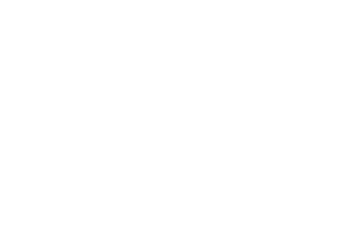

In [50]:
# creating training and testing data

images = []
labels = []
#print("here")
for img_path in glob.glob("full_noise/Nrms1p0/*.jpg"): #make sure you have correct file path
    label = labeling(separation(img_path, True), separation(img_path, False))
    print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #calculating horizontal edges using prewitt kernel
    #img = prewitt_h(img)
    img = detect_hog(img)
    if len(img) == 336:
        images.append(img)
        labels.append(label)

In [37]:
#converting to np array
images = np.array(images)
labels = np.array(labels)

In [38]:
labels[:10]

array(['ssee', 'nnee', 'sw', 'nee', 'see', 'nee', 'nee', 'sse', 'ne',
       'ssww'], dtype='<U4')

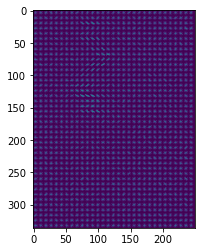

(<matplotlib.image.AxesImage at 0x7f91b02a5e20>, None)

In [39]:
plt.imshow(images[0]), plt.show()

In [40]:
#splitting into training and testing data
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.20, random_state=24)

In [41]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [42]:
#renamed train test split
x_train, x_test, y_train, y_test = train_images, test_images, train_labels_encoded, test_labels_encoded

In [43]:
x_train.shape, y_train.shape

((819, 336, 250), (819,))

In [44]:
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0
print(x_train.shape)
print(x_test.shape)

(819, 336, 250)
(205, 336, 250)


In [45]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny))

#so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples,nx*ny))

In [ ]:
x_train2.shape, x_test.shape

In [18]:
#import classifiers
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
# base_model = XGBClassifier(objective="multi:softmax",
#                            seed=24,
#                            verbosity=2,
#                            max_depth=9)
# param = {
#     'learning_rate': [0.08, 1, 1.02]
# }

# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param,
#     scoring = 'accuracy',
#     cv=3,
#     verbose=3
# )

In [20]:
# grid_search.fit(x_train2, y_train)

In [ ]:
#training classifier
xgb1 = XGBClassifier(learning_rate=0.08, verbosity=2, objective="multi:softmax", seed=24)
xgb1.fit(x_train2, y_train)

[15:04:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[15:04:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[15:04:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:04:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:04:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:04:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:04:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:04:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:04:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, m

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=24, reg_alpha=0, ...)

In [ ]:
# print('\n All results:')
# print(grid_search.cv_results_)

In [ ]:
#make predictions for test data
y_pred = xgb1.predict(x_test2)
predictions = [round(value) for value in y_pred]

In [ ]:
#print accuracy
accuracy_score(y_test, predictions)

0.9073170731707317

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.73%


<AxesSubplot:>

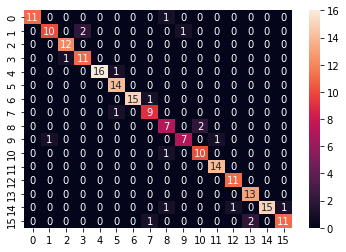

In [ ]:
import seaborn as sns
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)